# Data Analysis and Preprocessing

This notebook performs data loading, exploration, and preprocessing for the LitBank NER project.

**Outputs:**
- `data/flattened_data.pkl` - Preprocessed train, validation, and test datasets
- `data/tag_mappings.json` - NER tag mappings (tag2idx, idx2tag, PAD_TAG_IDX)
- `data/vocabulary.json` - Word vocabulary (word2idx)

**Next Step:** Use `litbank_ner_fasttext.ipynb` for model training and evaluation.

## 1. Load LitBank Dataset

LitBank is loaded from Hugging Face. It contains literary texts annotated with Named entities, Coreference chains and Events.

In [1]:
# Import the datasets library from Hugging Face
from datasets import load_dataset

# Load LitBank dataset from Hugging Face
try:
    # Load the dataset with split_0 configuration
    dataset = load_dataset("coref-data/litbank_raw", "split_0")
    print("LitBank dataset loaded successfully!")
    # Display the dataset structure (train/validation/test splits)
    print(f"Dataset structure: {dataset}")
except Exception as e:
    # If loading fails, print error message
    print(f"Error loading dataset: {e}")
    print("You may need to download LitBank manually from https://github.com/dbamman/litbank")

LitBank dataset loaded successfully!
Dataset structure: DatasetDict({
    train: Dataset({
        features: ['doc_name', 'meta_info', 'sentences', 'coref_chains', 'entities', 'events', 'original_text', 'quotes'],
        num_rows: 80
    })
    validation: Dataset({
        features: ['doc_name', 'meta_info', 'sentences', 'coref_chains', 'entities', 'events', 'original_text', 'quotes'],
        num_rows: 10
    })
    test: Dataset({
        features: ['doc_name', 'meta_info', 'sentences', 'coref_chains', 'entities', 'events', 'original_text', 'quotes'],
        num_rows: 10
    })
})


## 2. Understanding the Dataset Structure

LitBank has a nested structure. The following cells explore the structure and analyse the contents
* there are 100 rows, each corresponding to a separate literary work from the period of 1719 to 1922 (for complete list see https://github.com/dbamman/litbank)
* the dataset contains an extract of ~2000 tokens per book, the number of sentences varies according to the sentence length (see sentence length analysis below)
* the total annotated dataset contains 210,532 tokens (rather small)

In [2]:
import pandas as pd

# DOCUMENT-LEVEL VIEW: Show all features from first 5 documents in a table
print("DOCUMENT-LEVEL OVERVIEW - ALL FEATURES")

# Convert first 5 documents to DataFrame
df_docs = pd.DataFrame(dataset['train'][:5])
df_docs

DOCUMENT-LEVEL OVERVIEW - ALL FEATURES


,doc_name,meta_info,sentences,coref_chains,entities,events,original_text,quotes
0,2489_moby_dick,"{'author': 'Melville, Herman', 'date': '1851',...","[[CHAPTER, 1, Loomings, Call, me, Ishmael, .],...","[[[0, 4, 4], [0, 5, 5], [1, 16, 16], [1, 24, 2...","[[{'bio_tags': ['O', 'O', 'O', 'O', ''], 'toke...","[[{'is_event': False, 'token': 'CHAPTER'}, {'i...",CHAPTER 1\n\n Loomings\n\n\n\nCall me Ishmae...,[]
1,145_middlemarch,"{'author': 'Eliot, George', 'date': '1871', 'g...","[[BOOK, I., MISS, BROOKE, .], [CHAPTER, I., "",...","[[[0, 2, 3], [3, 0, 1], [4, 0, 0], [4, 9, 9], ...","[[{'bio_tags': ['O', 'O', 'O', 'O', ''], 'toke...","[[{'is_event': False, 'token': 'BOOK'}, {'is_e...",BOOK I.\n\nMISS BROOKE.\n\n\n\nCHAPTER I.\n\n ...,[{'attribution': 'an_amiable_handsome_baronet-...
2,11231_bartleby_the_scrivener_a_story_of_wallst...,"{'author': 'Melville, Herman', 'date': '1853',...","[[I, am, a, rather, elderly, man, .], [The, na...","[[[0, 0, 0], [1, 3, 3], [1, 12, 12], [1, 37, 3...","[[{'bio_tags': ['O', 'O', 'O', 'O', ''], 'toke...","[[{'is_event': False, 'token': 'I'}, {'is_even...",I am a rather elderly man. The nature of my a...,"[{'attribution': 'Turkey-28', 'end': {'sent_id..."
3,434_the_circular_staircase,"{'author': 'Rinehart, Mary Roberts', 'date': '...","[[CHAPTER, I, I, TAKE, A, COUNTRY, HOUSE, This...","[[[0, 2, 2], [0, 13, 15], [0, 17, 17], [0, 21,...","[[{'bio_tags': ['O', 'O', 'O', 'O', ''], 'toke...","[[{'is_event': False, 'token': 'CHAPTER'}, {'i...",CHAPTER I\n\nI TAKE A COUNTRY HOUSE\n\nThis is...,"[{'attribution': 'narrator-0', 'end': {'sent_i..."
4,2005_piccadilly_jim,"{'author': 'Wodehouse, P. G. (Pelham Grenville...","[[CHAPTER, I, A, RED-HAIRED, GIRL, The, reside...","[[[0, 2, 4]], [[0, 8, 10], [5, 22, 23], [6, 7,...","[[{'bio_tags': ['O', 'O', 'O', 'O', ''], 'toke...","[[{'is_event': False, 'token': 'CHAPTER'}, {'i...",CHAPTER I\n\nA RED-HAIRED GIRL\n\nThe residenc...,"[{'attribution': 'Mr__Peter_Pett-2', 'end': {'..."


For this project, I am not interested in coreference chains or events. The relevant information will be in the columns `sentences` (tokens) and `entities` (NER tags).

In [3]:
# Explore the first example in the training set
if 'train' in dataset and len(dataset['train']) > 0:
    # Get the first sample from training data
    sample = dataset['train'][0]
    
    # Show the structure of sentences (nested list)
    print("SENTENCES structure:")
    print(f"Number of sentences in first document: {len(sample['sentences'])}")
    print(f"First sentence tokens: {sample['sentences'][0]}")
    print(f"Second sentence tokens: {sample['sentences'][1]}")
    
    # Show the structure of entities (nested list with dicts)
    print("\nENTITIES structure:")
    print(f"Number of entity lists: {len(sample['entities'])}")
    print(f"Entities in first sentence: {sample['entities'][0][:5]}")  # Show first 5 entities
    
else:
    print("No training data available")

SENTENCES structure:
Number of sentences in first document: 94
First sentence tokens: ['CHAPTER', '1', 'Loomings', 'Call', 'me', 'Ishmael', '.']
Second sentence tokens: ['Some', 'years', 'ago', '--', 'never', 'mind', 'how', 'long', 'precisely', '--', 'having', 'little', 'or', 'no', 'money', 'in', 'my', 'purse', ',', 'and', 'nothing', 'particular', 'to', 'interest', 'me', 'on', 'shore', ',', 'I', 'thought', 'I', 'would', 'sail', 'about', 'a', 'little', 'and', 'see', 'the', 'watery', 'part', 'of', 'the', 'world', '.']

ENTITIES structure:
Number of entity lists: 94
Entities in first sentence: [{'bio_tags': ['O', 'O', 'O', 'O', ''], 'token': 'CHAPTER'}, {'bio_tags': ['O', 'O', 'O', 'O', ''], 'token': '1'}, {'bio_tags': ['O', 'O', 'O', 'O', ''], 'token': 'Loomings'}, {'bio_tags': ['O', 'O', 'O', 'O', ''], 'token': 'Call'}, {'bio_tags': ['O', 'O', 'O', 'O', ''], 'token': 'me'}]


Every token has a NER tag that is either 0 (no recognised entity) or one of 6 entities: 
* Person (PER)
* Location (LOC)
* Facility (FAC)
* Geopolitical entity (GPE)
* Vehicle (VEC)
* Organisation (ORG)  

Each tag (`bio_tags`) can be of `B-type` (first token of an entity) or `I-type` (intermediate or any token following the first one in an entity that has more than one token).

NB: the annotation allows for nested entities, i.e. one token can be part of several entities (e.g. in `Mary's house` the token `Mary` would be a PER as well as part of an entity LOC). For each token there is a dictionary containing the token itself and the `bio_tags`for several annotation levels. 
* Layer 0 is used for primary annotation (13.7% of tokens).
* Layers 1-2 show nested entity annotations (fairly common, 6% of tokens).
* Layer 3 shows deep nesting (very rare - only 0.1% of tokens).
* Layer 4 is never used in this dataset.

For simplicity in this notebook only the first layer of annotation is used for training. It is true that some of the annotation information is lost. In a more sophisticated approach it would be necessary to use all layers or combine them into a richer annotation scheme.

## 3. Flatten Dataset Structure

The model needs flat lists of tokens and tags. The following function will convert LitBank's nested structure into sentence-level examples.

**Input**: Nested structure, organised by document. The tokens and NER tags are in the feature `entities`.  
**Output**: Each sentence becomes its own example with a flat structure (`tokens` + `ner_tags`). Each token has exactly one tag (only layer 0 is used, see above)

In [4]:
def flatten_litbank_data(dataset_split):
    flattened_examples = []  # Store all flattened sentences here
    
    # Loop through each document in the dataset
    for doc_idx, example in enumerate(dataset_split):
        # Get all sentences in this document (list of token lists)
        sentences = example.get('sentences', [])
        # Get all entities in this document (list of entity lists per sentence)
        entities = example.get('entities', [])
        
        # Process each sentence in the document
        for sent_idx, sentence_tokens in enumerate(sentences):
            # Skip empty sentences
            if not sentence_tokens:
                continue
            
            # Get entities for this specific sentence, entities are aligned with sentences (entities[i] corresponds to sentences[i])
            sent_entities = entities[sent_idx] if sent_idx < len(entities) else []
            
            # Create a mapping from token to its NER tag, each token in sentence_tokens needs a corresponding tag
            token_to_tag = {}  # Dictionary: token_index -> NER tag
            
            # Process each entity in this sentence
            for entity_dict in sent_entities:
                # Each entity has 'token' (the word) and 'bio_tags' (its NER label, layer 0)
                token = entity_dict.get('token', '')
                bio_tags = entity_dict.get('bio_tags', [])
                
                # bio_tags can be a list (for multi-word entities) or single string
                if isinstance(bio_tags, list) and len(bio_tags) > 0:
                    # Take the first tag if it's a list
                    tag = bio_tags[0] if bio_tags[0] else 'O'
                elif isinstance(bio_tags, str):
                    # Use the tag directly if it's a string
                    tag = bio_tags if bio_tags else 'O'
                else:
                    # Default to 'O' (outside entity) if no tag
                    tag = 'O'
                
                # Find this token in the sentence and record its tag
                # We search for the token's position to align it
                for token_idx, sent_token in enumerate(sentence_tokens):
                    # If token matches and hasn't been tagged yet
                    if sent_token == token and token_idx not in token_to_tag:
                        token_to_tag[token_idx] = tag
                        break  # Found it, move to next entity
            
            # Create the final list of tags aligned with tokens, any token not in token_to_tag gets 'O' (outside entity)
            ner_tags = [token_to_tag.get(i, 'O') for i in range(len(sentence_tokens))]
            
            # Add this sentence as a flat example
            flattened_examples.append({
                'tokens': sentence_tokens,  # List of words
                'ner_tags': ner_tags,  # List of NER labels (same length)
                'doc_idx': doc_idx,  # Track which document it came from
                'sent_idx': sent_idx  # Track which sentence in the document
            })
    
    return flattened_examples

# Flatten all dataset splits
train_data = flatten_litbank_data(dataset['train']) 
val_data = flatten_litbank_data(dataset['validation']) 
test_data = flatten_litbank_data(dataset['test']) 

# Print statistics
print(f"\nFlattened data statistics:")
print(f"Training sentences: {len(train_data)}")
print(f"Validation sentences: {len(val_data)}")
print(f"Test sentences: {len(test_data)}")

# Show an example
print(f"\nExample sentence:")
print(f"Tokens: {train_data[0]['tokens'][:15]}...")  # First 15 tokens
print(f"Tags:   {train_data[0]['ner_tags'][:15]}...")  # Corresponding tags


Flattened data statistics:
Training sentences: 6755
Validation sentences: 927
Test sentences: 880

Example sentence:
Tokens: ['CHAPTER', '1', 'Loomings', 'Call', 'me', 'Ishmael', '.']...
Tags:   ['O', 'O', 'O', 'O', 'O', 'B-PER', 'O']...


## 4. NER Tag Distribution and Tag Mapping

The next few cells analyse the types of entities that appear in LitBank and how frequently. This is important to understand the class imbalance: the training data shows a big imbalance, 86% of the tokens are tagged `0` (i.e. no entity). 
* Choosing the right evaluation metric: accuracy is probably misleading. If the model does not learn to recognise any entity, it will still be correct in 86% of cases. Precision, recall or the F1 score are better. For accuracy, 86% would be the baseline to check if the model has learned anything at all.
* *Data strategies: Weight the loss function to make the model care more about rare classes (entities) than common ones (O) or oversample minority classes (Show the model more examples of rare entity types).*


NER Tag Distribution:
B-FAC          :   1513 occurrences ( 0.89%)
B-GPE          :    675 occurrences ( 0.40%)
B-LOC          :    838 occurrences ( 0.49%)
B-ORG          :     88 occurrences ( 0.05%)
B-PER          :   6383 occurrences ( 3.77%)
B-VEH          :    163 occurrences ( 0.10%)
I-FAC          :   2237 occurrences ( 1.32%)
I-GPE          :    467 occurrences ( 0.28%)
I-LOC          :   1383 occurrences ( 0.82%)
I-ORG          :    172 occurrences ( 0.10%)
I-PER          :   9066 occurrences ( 5.35%)
I-VEH          :    241 occurrences ( 0.14%)
O              : 146230 occurrences (86.29%)


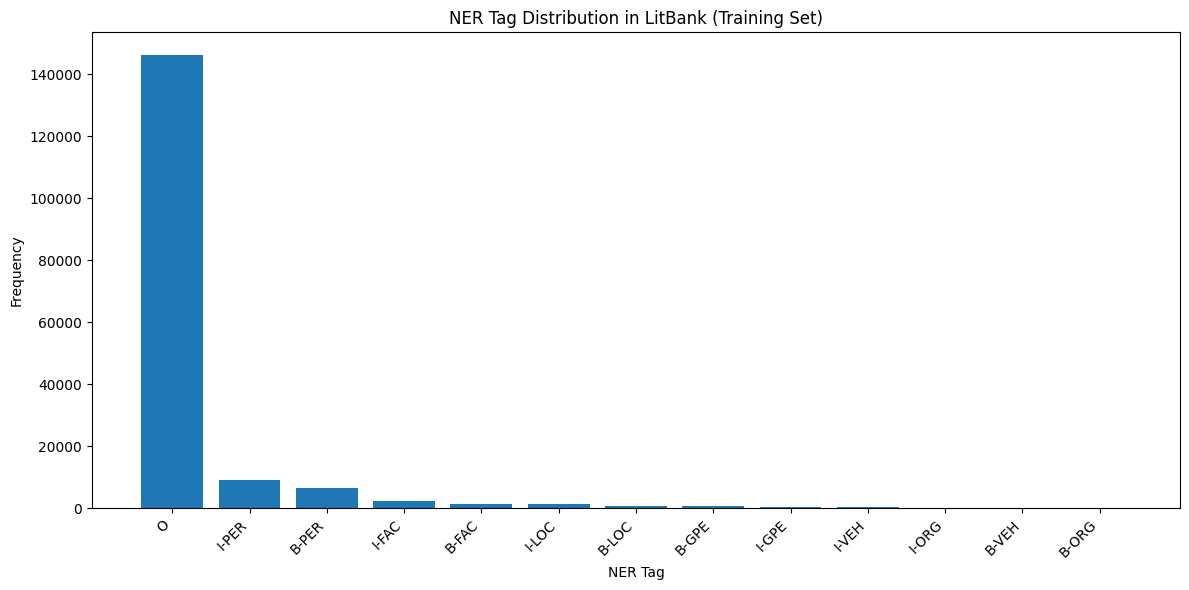


Entity Tags Only (excluding 'O'):


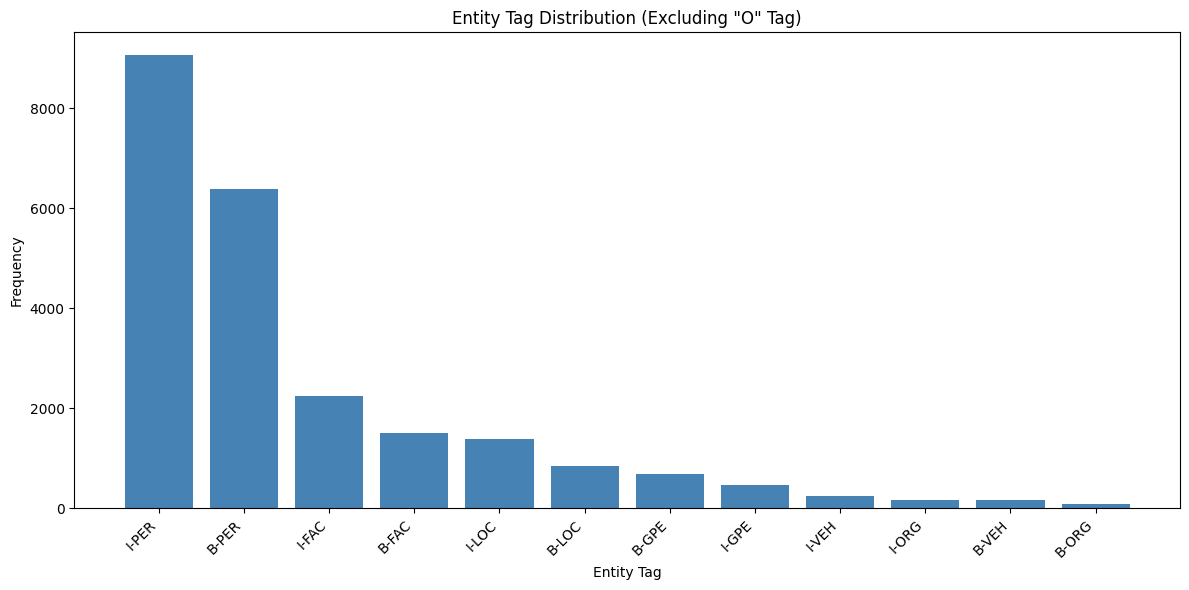

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

# Count all NER tags in the training data
def get_tag_distribution(flattened_data):
    """Count how many times each NER tag appears."""
    all_tags = []  # Collect all tags
    
    # Loop through each sentence
    for example in flattened_data:
        # Add all tags from this sentence to our list
        all_tags.extend(example['ner_tags'])
    
    # Count occurrences of each tag
    return Counter(all_tags)

# Get tag distribution from training data
tag_dist = get_tag_distribution(train_data)

# Print the distribution
print("\nNER Tag Distribution:")
for tag, count in sorted(tag_dist.items()):
    # Calculate percentage
    percentage = (count / sum(tag_dist.values())) * 100
    print(f"{tag:15s}: {count:6d} occurrences ({percentage:5.2f}%)")

# Visualize the distribution
plt.figure(figsize=(12, 6))
# Sort tags by count for better visualization
sorted_tags = sorted(tag_dist.items(), key=lambda x: x[1], reverse=True)
tags, counts = zip(*sorted_tags)
# Create bar plot
plt.bar(range(len(tags)), counts)
plt.xticks(range(len(tags)), tags, rotation=45, ha='right')
plt.xlabel('NER Tag')
plt.ylabel('Frequency')
plt.title('NER Tag Distribution in LitBank (Training Set)')
plt.tight_layout()
plt.show()

# Also show distribution without 'O' tag for better visibility of entities
entity_tags = {tag: count for tag, count in tag_dist.items() if tag != 'O'}
if entity_tags:
    print("\nEntity Tags Only (excluding 'O'):")
    plt.figure(figsize=(12, 6))
    sorted_entity_tags = sorted(entity_tags.items(), key=lambda x: x[1], reverse=True)
    tags, counts = zip(*sorted_entity_tags)
    plt.bar(range(len(tags)), counts, color='steelblue')
    plt.xticks(range(len(tags)), tags, rotation=45, ha='right')
    plt.xlabel('Entity Tag')
    plt.ylabel('Frequency')
    plt.title('Entity Tag Distribution (Excluding "O" Tag)')
    plt.tight_layout()
    plt.show()

**Create Tag Mappings**

The following cell creates two dictionaries to "translate" the tags to numbers and back again:
* `tag2idx`: Tag names (like "B-PER") → numbers (like 0, 1, 2...)
* `idx2tags`: Numbers → tag names (for interpreting predictions)

The tag `0` will be added as a separate tag in order to avoid confusion with padding added further on.

In [6]:
# Extract all unique tags from the training data
all_tags = set()  # create a set to get unique values only
for example in train_data:
    # Add all tags from this sentence to the set
    all_tags.update(example['ner_tags'])

# Sort alphabetically, 'O' will get a valid index (not 0)
tag_names = sorted(all_tags)

# Create mapping: tag name → number (for converting labels to model input)
tag2idx = {tag: idx for idx, tag in enumerate(tag_names)}

# Create reverse mapping: number → tag name (for converting predictions to readable tags)
idx2tag = {idx: tag for idx, tag in enumerate(tag_names)}

# Define a special padding index that doesn't conflict with any tag (-100 is a common choice for ignored indices in PyTorch)
PAD_TAG_IDX = -100

# Print the mappings
print("Tag to Index Mapping:")
for tag, idx in sorted(tag2idx.items(), key=lambda x: x[1]):
    print(f"  {tag:15s} → {idx}")

print(f"\nPadding tag index: {PAD_TAG_IDX} (will be ignored in loss calculation)")
print(f"Total unique tags: {len(tag_names)}")

Tag to Index Mapping:
  B-FAC           → 0
  B-GPE           → 1
  B-LOC           → 2
  B-ORG           → 3
  B-PER           → 4
  B-VEH           → 5
  I-FAC           → 6
  I-GPE           → 7
  I-LOC           → 8
  I-ORG           → 9
  I-PER           → 10
  I-VEH           → 11
  O               → 12

Padding tag index: -100 (will be ignored in loss calculation)
Total unique tags: 13


## 5. Analyze Sentence Lengths and Build Vocabulary

Understanding sentence length distribution helps us choose the right maximum sequence length (`MAX_LEN`) for the model (needs inputs of consistent, predictable size).  
The hyperparameter `MAX_LEN` will determine how much shorter sentences will be padded or where longer sentences are truncated.

Sentence Length Statistics:
  Mean:   25.09 tokens
  Median: 20 tokens
  Std:    20.49 tokens
  Min:    1 tokens
  Max:    307 tokens

Percentiles:
  50th percentile: 20 tokens
  75th percentile: 33 tokens
  90th percentile: 50 tokens
  95th percentile: 62 tokens
  99th percentile: 97 tokens


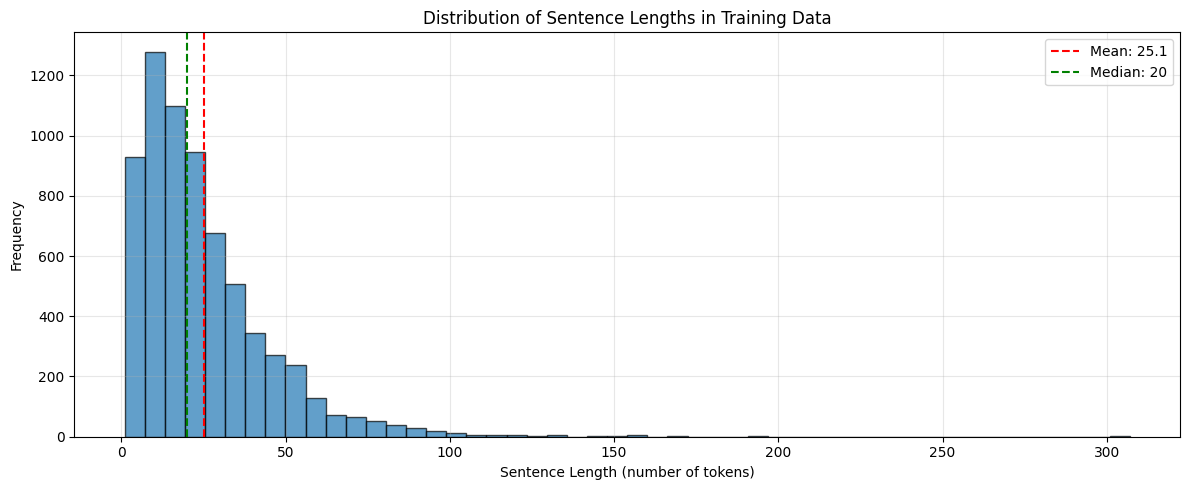


Recommended MAX_LEN: 62 (covers 95% of sentences)

Total unique words (before filtering): 14735
Vocabulary size (min_freq=2): 7265
Words filtered out: 7472

Sample vocabulary words: ['chapter', '1', 'call', 'me', '.', 'some', 'years', 'ago', '--', 'never', 'mind', 'how', 'long', 'precisely', 'having', 'little', 'or', 'no', 'money', 'in']

Special tokens:
  <PAD> index: 0
  <UNK> index: 1


In [7]:
import numpy as np

# Calculate length of each sentence (number of tokens)
sentence_lengths = [len(example['tokens']) for example in train_data]

# Calculate statistics
print(f"Sentence Length Statistics:")
print(f"  Mean:   {np.mean(sentence_lengths):.2f} tokens")
print(f"  Median: {np.median(sentence_lengths):.0f} tokens")
print(f"  Std:    {np.std(sentence_lengths):.2f} tokens")
print(f"  Min:    {np.min(sentence_lengths)} tokens")
print(f"  Max:    {np.max(sentence_lengths)} tokens")

# Calculate percentiles to help choose max_len
percentiles = [50, 75, 90, 95, 99]
print(f"\nPercentiles:")
for p in percentiles:
    value = np.percentile(sentence_lengths, p)
    print(f"  {p}th percentile: {value:.0f} tokens")

# Visualize the distribution
plt.figure(figsize=(12, 5))
plt.hist(sentence_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(sentence_lengths), color='red', linestyle='--', 
            label=f'Mean: {np.mean(sentence_lengths):.1f}')
plt.axvline(np.median(sentence_lengths), color='green', linestyle='--', 
            label=f'Median: {np.median(sentence_lengths):.0f}')
plt.xlabel('Sentence Length (number of tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths in Training Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Suggest a good max_len value
recommended_max_len = int(np.percentile(sentence_lengths, 95))
print(f"\nRecommended MAX_LEN: {recommended_max_len} (covers 95% of sentences)")

# Build vocabulary from training data
def build_vocab(flattened_data, min_freq=2):
    """
    Build vocabulary from training data.
    
    Args:
        flattened_data: List of sentence dicts with 'tokens'
        min_freq: Minimum frequency for a word to be included (default=2)
                  Words appearing less than this become <UNK> (unknown)
    
    Returns:
        word2idx: Dictionary mapping words to indices
        vocab: List of all words in vocabulary
    """
    # Count how many times each word appears
    word_freq = Counter()
    for example in flattened_data:
        # Convert to lowercase for case-insensitive vocabulary
        word_freq.update([token.lower() for token in example['tokens']])
    
    # Build vocabulary: special tokens first, then frequent words
    # <PAD>: Padding token (index 0) - used to make all sequences same length
    # <UNK>: Unknown token (index 1) - used for words not in vocabulary
    vocab = ['<PAD>', '<UNK>']
    
    # Add words that appear at least min_freq times
    vocab.extend([word for word, freq in word_freq.items() if freq >= min_freq])
    
    # Create mapping: word → index
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    
    # Print statistics
    print(f"\nTotal unique words (before filtering): {len(word_freq)}")
    print(f"Vocabulary size (min_freq={min_freq}): {len(vocab)}")
    print(f"Words filtered out: {len(word_freq) - (len(vocab) - 2)}")
    
    return word2idx, vocab

# Build vocabulary from training data
word2idx, vocab = build_vocab(train_data, min_freq=2)

# Show some example words from vocabulary
print(f"\nSample vocabulary words: {vocab[2:22]}")  # Skip <PAD> and <UNK>
print(f"\nSpecial tokens:")
print(f"  <PAD> index: {word2idx['<PAD>']}")
print(f"  <UNK> index: {word2idx['<UNK>']}")

## 6. Save Preprocessed Data

Save the preprocessed data, tag mappings, and vocabulary to the `data/` directory for use in model training.

In [8]:
import pickle
import json
from pathlib import Path

# Create data directory if it doesn't exist
data_dir = Path('../data')
data_dir.mkdir(exist_ok=True)

# Save flattened datasets
print('Saving flattened datasets...')
with open(data_dir / 'flattened_data.pkl', 'wb') as f:
    pickle.dump({
        'train_data': train_data,
        'val_data': val_data,
        'test_data': test_data
    }, f)
print(f'  Saved flattened_data.pkl ({len(train_data)} train, {len(val_data)} val, {len(test_data)} test samples)')

# Save tag mappings
print('Saving tag mappings...')
with open(data_dir / 'tag_mappings.json', 'w') as f:
    json.dump({
        'tag2idx': tag2idx,
        'idx2tag': idx2tag,
        'PAD_TAG_IDX': PAD_TAG_IDX
    }, f, indent=2)
print(f'  Saved tag_mappings.json ({len(tag2idx)} tags)')

# Save vocabulary
print('Saving vocabulary...')
with open(data_dir / 'vocabulary.json', 'w') as f:
    json.dump({
        'word2idx': word2idx,
        'vocab_size': len(word2idx)
    }, f, indent=2)
print(f'  Saved vocabulary.json ({len(word2idx)} words)')

print('\nAll preprocessing data saved successfully!')

Saving flattened datasets...
  Saved flattened_data.pkl (6755 train, 927 val, 880 test samples)
Saving tag mappings...
  Saved tag_mappings.json (13 tags)
Saving vocabulary...
  Saved vocabulary.json (7265 words)

All preprocessing data saved successfully!
